# Packages

In [9]:
import pickle

# Importer les modèles LR et AR(1) et AR(p)

In [1]:
# ==========================================
# Chargement AR(1) + Linéaire (robuste)
# ==========================================
import os
import pickle
import joblib
import numpy as np
import pandas as pd

# ---------- Helpers ----------
def load_any(path):
    """Charge un objet avec joblib puis pickle si besoin."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"Fichier introuvable: {path}")
    try:
        return joblib.load(path)
    except Exception:
        with open(path, "rb") as f:
            return pickle.load(f)

def try_read_meta(path):
    """Lit un CSV méta (Series si 1 colonne, sinon DataFrame)."""
    try:
        meta = pd.read_csv(path, index_col=0)
        if meta.shape[1] == 1:
            meta = meta.iloc[:, 0]  # Series
        return meta
    except Exception as e:
        print(f"⚠️ Impossible de lire {path} : {e}")
        return None

def safe_meta_print(meta, keys):
    """Affiche les clés demandées sans lever d'erreur si elles manquent."""
    if meta is None:
        print("⚠️ Pas de méta disponible.")
        return
    # Convertit en dict pour accès uniforme
    if isinstance(meta, pd.Series):
        d = meta.to_dict()
    elif isinstance(meta, pd.DataFrame):
        # prend la 1ère ligne si DataFrame
        d = meta.iloc[0].to_dict()
    elif isinstance(meta, dict):
        d = meta
    else:
        print(f"(info) Type de méta inattendu: {type(meta)}")
        d = {}

    print("\n--- Métadonnées AR(1) (clé: valeur) ---")
    for k in keys:
        v = d.get(k, None)
        print(f"{k}: {v}")

def _normalize_month_start(s):
    s = pd.to_datetime(s, errors="coerce")
    if isinstance(s, pd.Series):
        return s.dt.to_period("M").dt.to_timestamp(how="start")
    if isinstance(s, pd.DatetimeIndex):
        return s.to_period("M").to_timestamp(how="start")
    return pd.Timestamp(s).to_period("M").to_timestamp(how="start")

In [2]:
# ---------- Fichiers ----------
AR1_LAST_PKL  = "AR1_last_trained_model.pkl"
AR1_LAST_META = "AR1_last_trained_model_meta.csv"
AR1_BUNDLE    = "AR1_h12_oos_bundle.pkl"

LINREG_PKL    = "linear_regression.pkl"
LINREG_META   = "linear_regression_meta.csv"

# 🔹 Ajout AR(p)
ARP_LAST_PKL  = "ARP_last_trained_model.pkl"
ARP_LAST_META = "ARP_last_trained_model_meta.csv"
ARP_BUNDLE    = "ARP_h12_oos_bundle.pkl"

In [3]:
# ---------- Chargements ----------
print("=== Chargement AR(1) ===")
try:
    ar1_model = load_any(AR1_LAST_PKL)
    print("✅ Modèle AR(1) chargé.")
except Exception as e:
    ar1_model = None
    print(f"⚠️ Modèle AR(1) non chargé : {e}")
ar1_meta  = try_read_meta(AR1_LAST_META)

try:
    ar1_bundle = load_any(AR1_BUNDLE)
    print("✅ Bundle AR(1) chargé (OOS h=12).")
except Exception as e:
    ar1_bundle = None
    print(f"⚠️ Bundle AR(1) non chargé : {e}")

print("\n=== Chargement AR(p) ===")
try:
    arp_model = load_any(ARP_LAST_PKL)
    print("✅ Modèle AR(p) chargé.")
except Exception as e:
    arp_model = None
    print(f"⚠️ Modèle AR(p) non chargé : {e}")
arp_meta = try_read_meta(ARP_LAST_META)

try:
    arp_bundle = load_any(ARP_BUNDLE)
    print("✅ Bundle AR(p) chargé (OOS h=12).")
except Exception as e:
    arp_bundle = None
    print(f"⚠️ Bundle AR(p) non chargé : {e}")

print("\n=== Chargement Régression Linéaire ===")
try:
    linreg_bundle = load_any(LINREG_PKL)   # dict avec 'oos_predictions', 'params', etc.
    print("✅ Régression linéaire chargée.")
except Exception as e:
    linreg_bundle = None
    print(f"⚠️ Régression linéaire non chargée : {e}")
linreg_meta = try_read_meta(LINREG_META)

# (optionnel) Petits aperçus
if isinstance(arp_meta, (pd.Series, pd.DataFrame)):
    print("\n--- Métadonnées AR(p) ---")
    cols = [c for c in ["model","p_used_last","trained_until","aic","bic","MAE_1983_89","RMSE_1983_89","R2_1983_89"] 
            if c in (arp_meta.index if isinstance(arp_meta, pd.Series) else arp_meta.columns)]
    try:
        print(arp_meta[cols])
    except Exception:
        print(arp_meta)

if isinstance(ar1_meta, (pd.Series, pd.DataFrame)):
    print("\n--- Métadonnées AR(1) ---")
    cols = [c for c in ["model","trained_until","aic","bic","mae_83_89","rmse_83_89","r2_83_89"] 
            if c in (ar1_meta.index if isinstance(ar1_meta, pd.Series) else ar1_meta.columns)]
    try:
        print(ar1_meta[cols])
    except Exception:
        print(ar1_meta)

=== Chargement AR(1) ===
✅ Modèle AR(1) chargé.
✅ Bundle AR(1) chargé (OOS h=12).

=== Chargement AR(p) ===
✅ Modèle AR(p) chargé.
✅ Bundle AR(p) chargé (OOS h=12).

=== Chargement Régression Linéaire ===
✅ Régression linéaire chargée.

--- Métadonnées AR(p) ---
   model  p_used_last trained_until
0  AR(p)            4    2024-08-01

--- Métadonnées AR(1) ---
   model trained_until
0  AR(1)    2024-08-01


In [4]:
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta

# ========= utilitaires =========
def _get(meta, key, default=None):
    if meta is None:
        return default
    if isinstance(meta, dict):
        return meta.get(key, default)
    if isinstance(meta, pd.Series):
        return meta.get(key, default)
    if isinstance(meta, pd.DataFrame) and key in meta.columns:
        return meta[key].iloc[0]
    return default

def _normalize_month_start(s):
    s = pd.to_datetime(s, errors="coerce")
    if isinstance(s, pd.Series):
        return s.dt.to_period("M").dt.to_timestamp(how="start")
    if isinstance(s, pd.DatetimeIndex):
        return s.to_period("M").to_timestamp(how="start")
    return pd.Timestamp(s).to_period("M").to_timestamp(how="start")

# ================= AR -> df_ar (préférence: bundle) =================
def build_df_ar(ar_bundle=None, ar1_meta=None):
    """
    Priorité: utiliser ar_bundle['oos_predictions'] (date, y_true, y_pred).
    Sinon, si df_stationary_train_unrate est dispo -> recalcul OOS h=12.
    Aucun fallback in-sample (dynamic=False) n'est autorisé.
    """
    # 1) Bundle dispo -> simple et sûr
    if ar_bundle is not None and isinstance(ar_bundle, dict) and "oos_predictions" in ar_bundle:
        df = ar_bundle["oos_predictions"].copy()
        if df.index.name is not None:
            df = df.reset_index()

        cols = {c.lower(): c for c in df.columns}
        date_col = cols.get("date") or cols.get("dates")
        true_col = cols.get("y_true") or cols.get("true")
        pred_col = cols.get("y_pred") or cols.get("pred") or cols.get("prediction")
        assert date_col and true_col and pred_col, f"Colonnes manquantes: {df.columns.tolist()}"

        df = df[[date_col, true_col, pred_col]].rename(columns={date_col:"date", true_col:"true", pred_col:"pred"})
        df["date"] = _normalize_month_start(df["date"])

        method_name = _get(ar_bundle.get("params", {}), "model", "AR1")
        lag = _get(ar_bundle.get("params", {}), "lag", _get(ar_bundle.get("params", {}), "order_p", 1))
        df["method"]      = method_name
        df["hyper_type"]  = _get(ar_bundle.get("params", {}), "hyper_type", "expanding_oos")
        df["features"]    = _get(ar_bundle, "features", 1)
        df["lag"]         = lag
        df["n_boot"]      = None
        df["winsorize"]   = None
        df["window_size"] = None

        df = df.reset_index(drop=True)
        print(f"✅ df_ar prêt — from ar_bundle — shape={df.shape}")
        return df

    # 2) Sinon recalcul OOS h=12 (expanding) si la série est dispo
    eval_start = pd.to_datetime(_get(ar1_meta, "eval_start", "1983-01-01"))
    eval_end   = pd.to_datetime(_get(ar1_meta, "eval_end",   "1989-12-31"))
    h          = int(_get(ar1_meta, "horizon", 12))
    min_train_n= int(_get(ar1_meta, "min_train_n", 36))
    p_used     = int(_get(ar1_meta, "order_p", _get(ar1_meta, "p_used", 1)))

    if "df_stationary_train_unrate" in globals():
        from statsmodels.tsa.ar_model import AutoReg
        y = globals()["df_stationary_train_unrate"].squeeze().sort_index().astype(float).dropna()
        y.index = pd.to_datetime(y.index).to_period("M").to_timestamp(how="start")
        y = y.asfreq("MS")

        rows = []
        last_t_end = y.index.max() - relativedelta(months=h)
        for t_end in y.index:
            if t_end > last_t_end:
                break
            y_tr = y.loc[:t_end]
            if len(y_tr) < min_train_n:
                continue
            ar = AutoReg(y_tr, lags=p_used, old_names=False).fit()
            fc = ar.predict(start=len(y_tr), end=len(y_tr) + h - 1)
            yhat_h = float(fc.iloc[-1])
            t_fore = t_end + relativedelta(months=h)
            if t_fore in y.index:
                rows.append((t_fore, float(y.loc[t_fore]), yhat_h))

        df = pd.DataFrame(rows, columns=["date", "true", "pred"]).sort_values("date")
        df["date"] = _normalize_month_start(df["date"])
        df = df[(df["date"] >= eval_start) & (df["date"] <= eval_end)].copy()

        df["method"]      = f"AR({p_used})"
        df["hyper_type"]  = "expanding_oos"
        df["features"]    = 1
        df["lag"]         = p_used
        df["n_boot"]      = None
        df["winsorize"]   = None
        df["window_size"] = None

        df = df.reset_index(drop=True)
        print(f"✅ df_ar prêt — OOS h={h} (expanding) — shape={df.shape}")
        return df

    # 3) Rien de dispo -> on refuse un fallback biaisé
    raise RuntimeError(
        "Impossible de construire df_ar: charge 'ar1_bundle' (AR1_h12_oos_bundle.pkl) "
        "ou fournis 'df_stationary_train_unrate' pour recalculer l’OOS. "
        "Pas de fallback in-sample autorisé."
    )

# ================= LinearRegression -> df_lin (identique) =================
def build_df_lin(linreg_bundle):
    oos = linreg_bundle["oos_predictions"].copy()
    if oos.index.name is not None:
        oos = oos.reset_index()

    cols = {c.lower(): c for c in oos.columns}
    date_col = cols.get("date") or cols.get("dates")
    true_col = cols.get("y_true") or cols.get("true")
    pred_col = cols.get("y_pred") or cols.get("pred") or cols.get("prediction")
    assert date_col and true_col and pred_col, f"Colonnes manquantes dans oos_predictions: {oos.columns.tolist()}"

    df = oos[[date_col, true_col, pred_col]].rename(columns={date_col: "date", true_col: "true", pred_col: "pred"})
    df["date"] = _normalize_month_start(df["date"])

    params = linreg_bundle.get("params", {}) or {}
    features = linreg_bundle.get("features", None)
    if isinstance(features, (list, tuple, set)):
        features = len(features)

    df["method"]      = params.get("model", "LinearRegression")
    df["hyper_type"]  = params.get("hyper_type", "kfold_block_gap")
    df["features"]    = features
    df["lag"]         = params.get("shift_lag", params.get("lag", None))
    df["n_boot"]      = params.get("n_boot", None)
    df["winsorize"]   = params.get("winsor_level", params.get("winsorize", None))
    df["window_size"] = params.get("window_size", None)

    df = df.reset_index(drop=True)
    print(f"✅ df_lin prêt — from oos_predictions — shape={df.shape}")
    return df

# ======= Construction =======
# - ar1_bundle: si tu l'as chargé (AR1_h12_oos_bundle.pkl)
# - ar1_meta:   meta CSV chargé
# - linreg_bundle: bundle chargé
df_ar1 = build_df_ar(ar_bundle=ar1_bundle if "ar1_bundle" in globals() else None,
                     ar1_meta=ar1_meta if "ar1_meta" in globals() else None)

df_lin = build_df_lin(linreg_bundle)

print("\nAperçu df_ar1:\n", df_ar1.head())
print("\nAperçu df_lin:\n", df_lin.head())

✅ df_ar prêt — from ar_bundle — shape=(741, 10)
✅ df_lin prêt — from oos_predictions — shape=(741, 10)

Aperçu df_ar1:
         date  true      pred method     hyper_type  features  lag n_boot  \
0 1963-12-01   0.0 -0.080890  AR(1)  expanding_oos         1    1   None   
1 1964-01-01  -0.1  0.141077  AR(1)  expanding_oos         1    1   None   
2 1964-02-01  -0.5  0.408114  AR(1)  expanding_oos         1    1   None   
3 1964-03-01  -0.3  0.242637  AR(1)  expanding_oos         1    1   None   
4 1964-04-01  -0.4  0.238955  AR(1)  expanding_oos         1    1   None   

  winsorize window_size  
0      None        None  
1      None        None  
2      None        None  
3      None        None  
4      None        None  

Aperçu df_lin:
         date  true      pred            method       hyper_type features  \
0 1963-12-01   0.0 -0.354113  LinearRegression  kfold_block_gap     None   
1 1964-01-01  -0.1 -0.282896  LinearRegression  kfold_block_gap     None   
2 1964-02-01  -0.5  1.

In [5]:
import numpy as np
import pandas as pd

# ========= utilitaires =========
def _get(meta, key, default=None):
    if meta is None:
        return default
    if isinstance(meta, dict):
        return meta.get(key, default)
    if isinstance(meta, pd.Series):
        return meta.get(key, default)
    if isinstance(meta, pd.DataFrame) and key in meta.columns:
        return meta[key].iloc[0]
    return default

def _normalize_month_start(s):
    s = pd.to_datetime(s, errors="coerce")
    if isinstance(s, pd.Series):
        return s.dt.to_period("M").dt.to_timestamp(how="start")
    if isinstance(s, pd.DatetimeIndex):
        return s.to_period("M").to_timestamp(how="start")
    return pd.Timestamp(s).to_period("M").to_timestamp(how="start")

# ========= AR générique (marche pour AR(p) et AR(1)) =========
def build_df_from_ar_bundle(ar_bundle, fallback_name="AR"):
    """
    Transforme un bundle AR quelconque en DataFrame standard:
    date, true, pred, method (+ p_used si présent), avec dates normalisées MS.
    """
    if ar_bundle is None or "oos_predictions" not in ar_bundle:
        return pd.DataFrame(columns=["date","true","pred","method"])

    df = ar_bundle["oos_predictions"].copy()
    if df.index.name is not None:
        df = df.reset_index()

    cols = {c.lower(): c for c in df.columns}
    date_col = cols.get("date") or cols.get("dates")
    true_col = cols.get("y_true") or cols.get("true")
    pred_col = cols.get("y_pred") or cols.get("pred") or cols.get("prediction")
    assert date_col and true_col and pred_col, f"Colonnes manquantes: {df.columns.tolist()}"

    out = df[[date_col, true_col, pred_col]].rename(columns={date_col:"date", true_col:"true", pred_col:"pred"})
    out["date"] = _normalize_month_start(out["date"])

    # nom de méthode issu du bundle; sinon fallback
    method_name = _get(ar_bundle.get("params", {}), "model", fallback_name)
    out["method"] = method_name

    # si le bundle expose p_used (cas AR(p)), on le garde
    if "p_used" in df.columns:
        out["p_used"] = df["p_used"].values

    # champs info (optionnels, utiles pour debug/inspection)
    out["hyper_type"]  = _get(ar_bundle.get("params", {}), "hyper_type", "expanding_oos")
    out["features"]    = _get(ar_bundle, "features", 1)
    out["lag"]         = _get(ar_bundle.get("params", {}), "lag", _get(ar_bundle.get("params", {}), "order_p", None))
    out["n_boot"]      = _get(ar_bundle.get("params", {}), "n_boot", None)
    out["winsorize"]   = _get(ar_bundle.get("params", {}), "winsorize", _get(ar_bundle.get("params", {}), "winsor_level", None))
    out["window_size"] = _get(ar_bundle.get("params", {}), "window_size", None)

    out = out.reset_index(drop=True)
    print(f"✅ df_{method_name} prêt — from bundle — shape={out.shape}")
    return out

# ========= LinearRegression -> df_lin =========
def build_df_lin(linreg_bundle):
    if linreg_bundle is None or "oos_predictions" not in linreg_bundle:
        return pd.DataFrame(columns=["date","true","pred","method"])

    oos = linreg_bundle["oos_predictions"].copy()
    if oos.index.name is not None:
        oos = oos.reset_index()

    cols = {c.lower(): c for c in oos.columns}
    date_col = cols.get("date") or cols.get("dates")
    true_col = cols.get("y_true") or cols.get("true")
    pred_col = cols.get("y_pred") or cols.get("pred") or cols.get("prediction")
    assert date_col and true_col and pred_col, f"Colonnes manquantes dans oos_predictions: {oos.columns.tolist()}"

    df = oos[[date_col, true_col, pred_col]].rename(columns={date_col: "date", true_col: "true", pred_col: "pred"})
    df["date"] = _normalize_month_start(df["date"])

    params = linreg_bundle.get("params", {}) or {}
    features = linreg_bundle.get("features", None)
    if isinstance(features, (list, tuple, set)):
        features = len(features)

    df["method"]      = params.get("model", "LinearRegression")
    df["hyper_type"]  = params.get("hyper_type", "kfold_block_gap")
    df["features"]    = features
    df["lag"]         = params.get("shift_lag", params.get("lag", None))
    df["n_boot"]      = params.get("n_boot", None)
    df["winsorize"]   = params.get("winsor_level", params.get("winsorize", None))
    df["window_size"] = params.get("window_size", None)

    df = df.reset_index(drop=True)
    print(f"✅ df_lin prêt — from oos_predictions — shape={df.shape}")
    return df

# ======= Construction des DF =======
dfs = []

# AR(p) (depuis arp_bundle chargé plus haut)
if "arp_bundle" in globals():
    df_arp = build_df_from_ar_bundle(arp_bundle, fallback_name="AR(p)")
    if not df_arp.empty:
        dfs.append(df_arp)

# AR(1) (depuis ar1_bundle chargé plus haut)
if "ar1_bundle" in globals():
    df_ar1 = build_df_from_ar_bundle(ar1_bundle, fallback_name="AR(1)")
    if not df_ar1.empty:
        dfs.append(df_ar1)

# LinearRegression
if "linreg_bundle" in globals():
    df_lin = build_df_lin(linreg_bundle)
    if not df_lin.empty:
        dfs.append(df_lin)

if len(dfs) == 0:
    raise RuntimeError("Aucun bundle exploitable (arp_bundle, ar1_bundle, linreg_bundle).")

# ======= Fusion finale =======
df_pred_long = pd.concat(dfs, ignore_index=True)

# Nettoyage colonnes non essentielles pour plots simples
cols_to_drop = ["hyper_type", "features", "lag", "n_boot", "winsorize", "window_size"]
df_pred_long = df_pred_long.drop(columns=[c for c in cols_to_drop if c in df_pred_long.columns])

# Tri & index propre
df_pred_long["date"] = pd.to_datetime(df_pred_long["date"])
df_pred_long = df_pred_long.sort_values(["date", "method"]).reset_index(drop=True)

print(f"\n✅ Fusion réussie — df_pred_long shape = {df_pred_long.shape}")
print("Colonnes :", df_pred_long.columns.tolist())
print("Méthodes :", df_pred_long["method"].unique().tolist())

print("\nAperçu des premières lignes :")
print(df_pred_long.head(10))

✅ df_AR(p) prêt — from bundle — shape=(741, 11)
✅ df_AR(1) prêt — from bundle — shape=(741, 10)
✅ df_lin prêt — from oos_predictions — shape=(741, 10)

✅ Fusion réussie — df_pred_long shape = (2223, 5)
Colonnes : ['date', 'true', 'pred', 'method', 'p_used']
Méthodes : ['AR(1)', 'AR(p)', 'LinearRegression']

Aperçu des premières lignes :
        date  true      pred            method  p_used
0 1963-12-01   0.0 -0.080890             AR(1)     NaN
1 1963-12-01   0.0 -0.080890             AR(p)     1.0
2 1963-12-01   0.0 -0.354113  LinearRegression     NaN
3 1964-01-01  -0.1  0.141077             AR(1)     NaN
4 1964-01-01  -0.1  0.141077             AR(p)     1.0
5 1964-01-01  -0.1 -0.282896  LinearRegression     NaN
6 1964-02-01  -0.5  0.408114             AR(1)     NaN
7 1964-02-01  -0.5  0.408114             AR(p)     1.0
8 1964-02-01  -0.5  1.105841  LinearRegression     NaN
9 1964-03-01  -0.3  0.242637             AR(1)     NaN


C:\Users\Mita\AppData\Local\Temp\ipykernel_10732\2889585463.py:126: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pred_long = pd.concat(dfs, ignore_index=True)


In [6]:
print(df_ar1.head())
print(df_lin.head())

        date  true      pred method     hyper_type  features  lag n_boot  \
0 1963-12-01   0.0 -0.080890  AR(1)  expanding_oos         1    1   None   
1 1964-01-01  -0.1  0.141077  AR(1)  expanding_oos         1    1   None   
2 1964-02-01  -0.5  0.408114  AR(1)  expanding_oos         1    1   None   
3 1964-03-01  -0.3  0.242637  AR(1)  expanding_oos         1    1   None   
4 1964-04-01  -0.4  0.238955  AR(1)  expanding_oos         1    1   None   

  winsorize window_size  
0      None        None  
1      None        None  
2      None        None  
3      None        None  
4      None        None  
        date  true      pred            method       hyper_type features  \
0 1963-12-01   0.0 -0.354113  LinearRegression  kfold_block_gap     None   
1 1964-01-01  -0.1 -0.282896  LinearRegression  kfold_block_gap     None   
2 1964-02-01  -0.5  1.105841  LinearRegression  kfold_block_gap     None   
3 1964-03-01  -0.3  1.241988  LinearRegression  kfold_block_gap     None   
4 1964-

In [7]:
# ==========================================
# 🔹 Fusion AR(p) + AR(1) + LinearRegression
# ==========================================

# Liste dynamique des DataFrames disponibles et non vides
dfs = []

if "df_arp" in globals() and isinstance(df_arp, pd.DataFrame) and not df_arp.empty:
    dfs.append(df_arp)
if "df_ar1" in globals() and isinstance(df_ar1, pd.DataFrame) and not df_ar1.empty:
    dfs.append(df_ar1)
if "df_lin" in globals() and isinstance(df_lin, pd.DataFrame) and not df_lin.empty:
    dfs.append(df_lin)

# Vérification : au moins un modèle présent
if len(dfs) == 0:
    raise RuntimeError("Aucun DataFrame disponible (df_arp, df_ar1, df_lin) pour la fusion.")

# Concaténation verticale
df_pred_long = pd.concat(dfs, ignore_index=True)

# Conversion en datetime et nettoyage
df_pred_long["date"] = pd.to_datetime(df_pred_long["date"], errors="coerce")
df_pred_long = df_pred_long.dropna(subset=["date", "true", "pred"]).sort_values(["date", "method"]).reset_index(drop=True)

# Suppression des colonnes purement techniques
cols_to_drop = ["hyper_type", "features", "lag", "n_boot", "winsorize", "window_size"]
df_pred_long = df_pred_long.drop(columns=[c for c in cols_to_drop if c in df_pred_long.columns], errors="ignore")

# ✅ Résumé
print(f"✅ Fusion réussie — df_pred_long shape = {df_pred_long.shape}")
print("Colonnes restantes :", df_pred_long.columns.tolist())
print("Méthodes présentes :", sorted(df_pred_long['method'].unique().tolist()))

# Aperçu du contenu
print("\nAperçu df_pred_long :")
print(df_pred_long.head(10))

✅ Fusion réussie — df_pred_long shape = (2223, 5)
Colonnes restantes : ['date', 'true', 'pred', 'method', 'p_used']
Méthodes présentes : ['AR(1)', 'AR(p)', 'LinearRegression']

Aperçu df_pred_long :
        date  true      pred            method  p_used
0 1963-12-01   0.0 -0.080890             AR(1)     NaN
1 1963-12-01   0.0 -0.080890             AR(p)     1.0
2 1963-12-01   0.0 -0.354113  LinearRegression     NaN
3 1964-01-01  -0.1  0.141077             AR(1)     NaN
4 1964-01-01  -0.1  0.141077             AR(p)     1.0
5 1964-01-01  -0.1 -0.282896  LinearRegression     NaN
6 1964-02-01  -0.5  0.408114             AR(1)     NaN
7 1964-02-01  -0.5  0.408114             AR(p)     1.0
8 1964-02-01  -0.5  1.105841  LinearRegression     NaN
9 1964-03-01  -0.3  0.242637             AR(1)     NaN


C:\Users\Mita\AppData\Local\Temp\ipykernel_10732\3545253842.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pred_long = pd.concat(dfs, ignore_index=True)


# Test

C:\Users\Mita\AppData\Local\Temp\ipykernel_5680\1887164954.py:61: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mita\AppData\Local\Temp\ipykernel_5680\1887164954.py:62: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.savefig("predictions_alignees_trois.png", dpi=150)
C:\Users\Mita\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


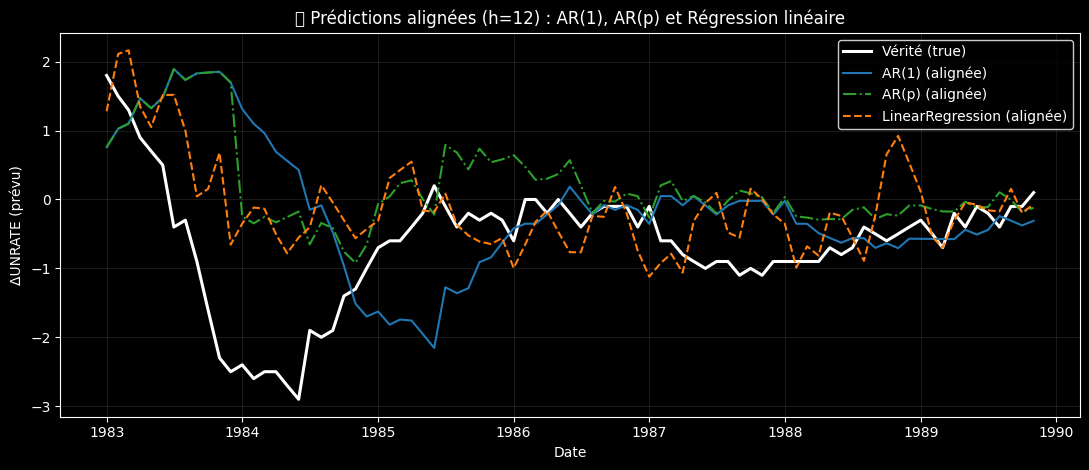

C:\Users\Mita\AppData\Local\Temp\ipykernel_5680\1887164954.py:87: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mita\AppData\Local\Temp\ipykernel_5680\1887164954.py:88: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.savefig("predictions_decalees_trois.png", dpi=150)


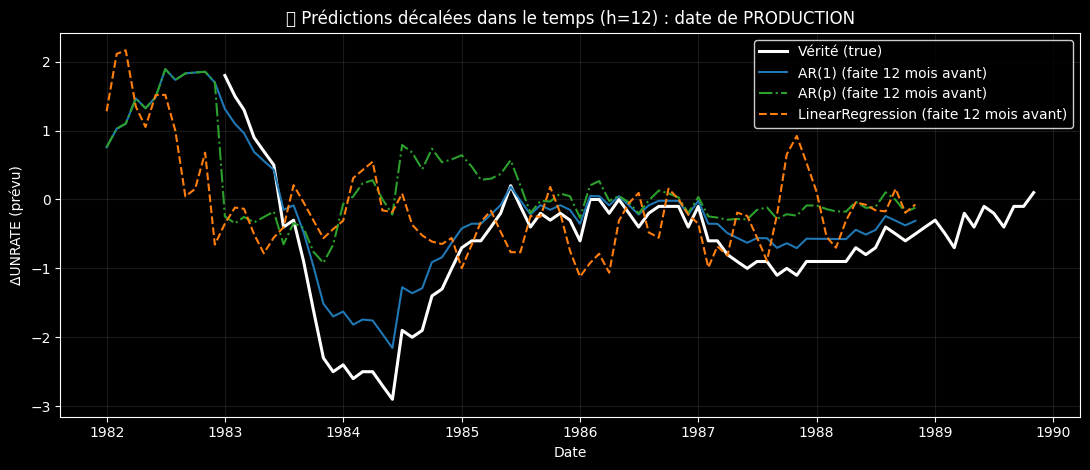

C:\Users\Mita\AppData\Local\Temp\ipykernel_5680\1887164954.py:111: UserWarning: Glyph 128312 (\N{SMALL ORANGE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mita\AppData\Local\Temp\ipykernel_5680\1887164954.py:112: UserWarning: Glyph 128312 (\N{SMALL ORANGE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.savefig("erreurs_absolues_trois.png", dpi=150)
C:\Users\Mita\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128312 (\N{SMALL ORANGE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


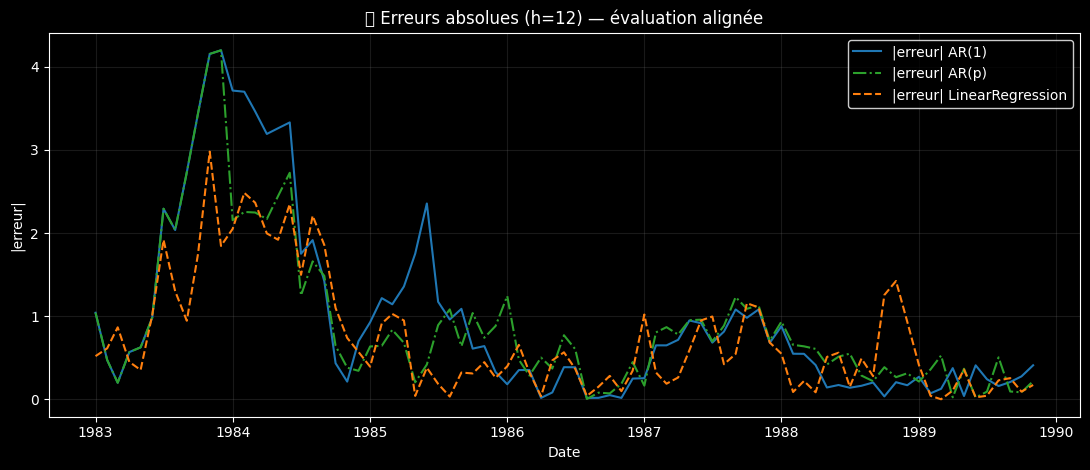

📁 Figures enregistrées :
  - predictions_alignees_trois.png
  - predictions_decalees_trois.png
  - erreurs_absolues_trois.png


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Paramètre d'horizon ===
H = 12  # mois

# === Préparation des données à partir de df_pred_long ===
dfl = df_pred_long.copy()
dfl["date"] = pd.to_datetime(dfl["date"])
dfl = dfl.sort_values(["date", "method"])

# Pivot large : colonnes = méthodes
wide = dfl.pivot(index="date", columns="method", values="pred")

# vérité unique par date
ytrue = dfl.drop_duplicates("date").set_index("date")["true"]
wide = wide.join(ytrue.rename("true")).dropna().sort_index()

# Vérification des modèles présents
has_ar1 = any(c in wide.columns for c in ["AR(1)", "AR1"])
has_arp = any(c.startswith("AR(") and c not in ["AR(1)", "AR1"] for c in wide.columns)
has_lr = "LinearRegression" in wide.columns

# Trouve le nom exact des colonnes (souplesse)
ar1_col = next((c for c in wide.columns if c in ["AR(1)", "AR1"]), None)
arp_col = next((c for c in wide.columns if c.startswith("AR(") and c not in ["AR(1)", "AR1"]), None)

# === Décalage temporel (pour montrer les dates de production des prévisions) ===
idx_shift = wide.index - pd.DateOffset(months=H)

# === Style graphique ===
plt.style.use("dark_background")
colors = {
    "AR(1)": "#1f77b4", "AR1": "#1f77b4",
    "AR(p)": "#2ca02c",
    "LinearRegression": "#ff7f0e",
    "true": "#ffffff"
}

# -------------------------------
# 1️⃣ PRÉVISIONS ALIGNÉES (comparaison directe vs vérité)
# -------------------------------
plt.figure(figsize=(11, 4.8))
plt.plot(wide.index, wide["true"], label="Vérité (true)", color=colors["true"], linewidth=2.2)

if has_ar1:
    plt.plot(wide.index, wide[ar1_col], label="AR(1) (alignée)", color=colors["AR(1)"], linestyle='-')

if has_arp:
    plt.plot(wide.index, wide[arp_col], label=f"{arp_col} (alignée)", color=colors["AR(p)"], linestyle='-.')

if has_lr:
    plt.plot(wide.index, wide["LinearRegression"], label="LinearRegression (alignée)",
             color=colors["LinearRegression"], linestyle='--')

plt.title(f"🔹 Prédictions alignées (h={H}) : AR(1), AR(p) et Régression linéaire")
plt.xlabel("Date"); plt.ylabel("ΔUNRATE (prévu)")
plt.legend(facecolor="black", edgecolor="white")
plt.grid(alpha=0.2, color="gray")
plt.tight_layout()
plt.savefig("predictions_alignees_trois.png", dpi=150)
plt.show()

# -------------------------------
# 2️⃣ PRÉVISIONS DÉCALÉES (affiche la date de PRODUCTION des prévisions)
# -------------------------------
plt.figure(figsize=(11, 4.8))
plt.plot(wide.index, wide["true"], label="Vérité (true)", color=colors["true"], linewidth=2.2)

if has_ar1:
    plt.plot(idx_shift, wide[ar1_col], label=f"{ar1_col} (faite {H} mois avant)",
             color=colors["AR(1)"], linestyle='-')

if has_arp:
    plt.plot(idx_shift, wide[arp_col], label=f"{arp_col} (faite {H} mois avant)",
             color=colors["AR(p)"], linestyle='-.')

if has_lr:
    plt.plot(idx_shift, wide["LinearRegression"], label=f"LinearRegression (faite {H} mois avant)",
             color=colors["LinearRegression"], linestyle='--')

plt.title(f"🔹 Prédictions décalées dans le temps (h={H}) : date de PRODUCTION")
plt.xlabel("Date"); plt.ylabel("ΔUNRATE (prévu)")
plt.legend(facecolor="black", edgecolor="white")
plt.grid(alpha=0.2, color="gray")
plt.tight_layout()
plt.savefig("predictions_decalees_trois.png", dpi=150)
plt.show()

# -------------------------------
# 3️⃣ ERREURS ABSOLUES (évaluation alignée)
# -------------------------------
plt.figure(figsize=(11, 4.8))
if has_ar1:
    plt.plot(wide.index, np.abs(wide["true"] - wide[ar1_col]),
             label="|erreur| AR(1)", color=colors["AR(1)"], linestyle='-')

if has_arp:
    plt.plot(wide.index, np.abs(wide["true"] - wide[arp_col]),
             label=f"|erreur| {arp_col}", color=colors["AR(p)"], linestyle='-.')

if has_lr:
    plt.plot(wide.index, np.abs(wide["true"] - wide["LinearRegression"]),
             label="|erreur| LinearRegression", color=colors["LinearRegression"], linestyle='--')

plt.title(f"🔸 Erreurs absolues (h={H}) — évaluation alignée")
plt.xlabel("Date"); plt.ylabel("|erreur|")
plt.legend(facecolor="black", edgecolor="white")
plt.grid(alpha=0.2, color="gray")
plt.tight_layout()
plt.savefig("erreurs_absolues_trois.png", dpi=150)
plt.show()

print("📁 Figures enregistrées :")
print("  - predictions_alignees_trois.png")
print("  - predictions_decalees_trois.png")
print("  - erreurs_absolues_trois.png")

In [50]:
import numpy as np
import pandas as pd
from math import erf, sqrt
from itertools import combinations

# ============================
# Paramètres
# ============================
H = 12  # horizon mois (=> NW lag = H-1)

# ============================
# 1) Métriques par modèle
# ============================
df = df_pred_long.copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["date", "method"]).reset_index(drop=True)

def _metrics(y_true, y_pred):
    e = np.asarray(y_pred, float) - np.asarray(y_true, float)
    mae  = float(np.mean(np.abs(e)))
    rmse = float(np.sqrt(np.mean(e**2)))
    bias = float(np.mean(e))
    ssr  = float(np.sum(e**2))
    sst  = float(np.sum((np.asarray(y_true, float) - np.mean(y_true))**2))
    r2   = float(1 - ssr/sst) if sst > 0 else np.nan
    return pd.Series({"MAE": mae, "RMSE": rmse, "Bias": bias, "R2": r2})

metrics = (
    df.groupby("method")[["true", "pred"]]
      .apply(lambda g: _metrics(g["true"], g["pred"]))
      .reset_index()
)

print("=== 📊 Métriques par modèle ===")
print(metrics.to_string(index=False))

# ============================
# 2) Diebold–Mariano helpers
# ============================
def _nw_var(d, lag):
    """Variance HAC (Newey–West, fenêtre Bartlett)."""
    d = np.asarray(d, float)
    d = d - d.mean()
    T = len(d)
    if T <= 1:
        return np.nan
    var = np.dot(d, d) / T
    for l in range(1, lag + 1):
        cov = np.dot(d[l:], d[:-l]) / T
        var += 2 * (1 - l / (lag + 1)) * cov
    return var

def dm_test(y, y1, y2, h=12, power=2, alternative="two_sided"):
    """
    Diebold–Mariano pour comparer y1 vs y2 à horizon h (perte |.|^power).
    Retourne (DM, pvalue). Alternative: 'two_sided' | 'less' | 'greater'
    """
    y  = np.asarray(y, float)
    y1 = np.asarray(y1, float)
    y2 = np.asarray(y2, float)
    e1, e2 = y - y1, y - y2
    l1 = np.abs(e1) if power == 1 else e1**2
    l2 = np.abs(e2) if power == 1 else e2**2
    d  = l1 - l2
    d_bar = float(np.mean(d))
    var_d = _nw_var(d, lag=max(h - 1, 0))
    if not np.isfinite(var_d) or var_d == 0:
        return np.nan, np.nan
    DM = d_bar / np.sqrt(var_d / len(d))
    # p-value normale
    cdf = lambda x: 0.5 * (1 + erf(x / sqrt(2)))
    if alternative == "two_sided":
        p = 2 * (1 - cdf(abs(DM)))
    elif alternative == "less":
        p = cdf(DM)
    else:  # "greater"
        p = 1 - cdf(DM)
    return float(DM), float(p)

# ============================
# 3) Alignement & paires à tester
# ============================
# On garde seulement les dates où la vérité est dispo
base = (df[["date","true"]]
        .drop_duplicates("date")
        .set_index("date")
        .sort_index())

# Liste des méthodes disponibles
methods = sorted(df["method"].unique().tolist())

# On met chaque méthode en colonne (prédictions)
pred_by_m = (
    df.pivot(index="date", columns="method", values="pred")
      .sort_index()
)

# Jointure avec la vérité
wide_all = pred_by_m.join(base, how="inner").dropna(subset=["true"])

# ============================
# 4) DM pairwise (MSE et MAE)
# ============================
rows_mse = []
rows_mae = []

for m1, m2 in combinations(methods, 2):
    # alignement sur les dates où les deux méthodes existent + vérité
    sub = wide_all.dropna(subset=[m1, m2])
    if len(sub) < 5:
        # échantillon trop petit
        rows_mse.append({"m1": m1, "m2": m2, "n": len(sub), "DM": np.nan, "pval": np.nan})
        rows_mae.append({"m1": m1, "m2": m2, "n": len(sub), "DM": np.nan, "pval": np.nan})
        continue

    # MSE
    DM_mse, p_mse = dm_test(sub["true"].values, sub[m1].values, sub[m2].values,
                            h=H, power=2, alternative="two_sided")
    rows_mse.append({"m1": m1, "m2": m2, "n": len(sub), "DM": DM_mse, "pval": p_mse})

    # MAE
    DM_mae, p_mae = dm_test(sub["true"].values, sub[m1].values, sub[m2].values,
                            h=H, power=1, alternative="two_sided")
    rows_mae.append({"m1": m1, "m2": m2, "n": len(sub), "DM": DM_mae, "pval": p_mae})

dm_table_mse = pd.DataFrame(rows_mse).sort_values(["m1","m2"]).reset_index(drop=True)
dm_table_mae = pd.DataFrame(rows_mae).sort_values(["m1","m2"]).reset_index(drop=True)

print("\n=== ⚖️ Diebold–Mariano — perte MSE (power=2), lag NW = H-1 ===")
print(dm_table_mse.to_string(index=False, formatters={"DM": "{:.3f}".format, "pval": "{:.4f}".format}))

print("\n=== ⚖️ Diebold–Mariano — perte MAE (power=1), lag NW = H-1 ===")
print(dm_table_mae.to_string(index=False, formatters={"DM": "{:.3f}".format, "pval": "{:.4f}".format}))

# Petit résumé lisible (seuil 5%)
def pretty_conclusion(row, loss="MSE"):
    if not np.isfinite(row["DM"]) or not np.isfinite(row["pval"]):
        return f"{row['m1']} vs {row['m2']}: test {loss} indéterminé (échantillon insuffisant)."
    if row["pval"] < 0.05:
        # DM > 0 => m1 a perte > m2 (donc m2 meilleur) ; DM < 0 => m1 meilleur
        better = row["m2"] if row["DM"] > 0 else row["m1"]
        return f"{row['m1']} vs {row['m2']} ({loss}): p={row['pval']:.4f} ⇒ {better} significativement meilleur (5%)."
    return f"{row['m1']} vs {row['m2']} ({loss}): p={row['pval']:.4f} ⇒ pas de différence significative."

print("\n--- Conclusions (seuil 5%) — MSE ---")
for _, r in dm_table_mse.iterrows():
    print(pretty_conclusion(r, "MSE"))

print("\n--- Conclusions (seuil 5%) — MAE ---")
for _, r in dm_table_mae.iterrows():
    print(pretty_conclusion(r, "MAE"))

=== 📊 Métriques par modèle ===
          method      MAE     RMSE     Bias        R2
           AR(1) 0.977554 1.461010 0.486680 -1.723767
           AR(p) 0.987562 1.351194 0.177502 -0.401641
LinearRegression 0.737050 1.009179 0.534018 -0.299573

=== ⚖️ Diebold–Mariano — perte MSE (power=2), lag NW = H-1 ===
   m1               m2  n    DM   pval
AR(1)            AR(p) 83 1.333 0.1826
AR(1) LinearRegression 83 1.474 0.1406
AR(p) LinearRegression 83 1.274 0.2025

=== ⚖️ Diebold–Mariano — perte MAE (power=1), lag NW = H-1 ===
   m1               m2  n    DM   pval
AR(1)            AR(p) 83 0.733 0.4637
AR(1) LinearRegression 83 1.547 0.1217
AR(p) LinearRegression 83 1.743 0.0813

--- Conclusions (seuil 5%) — MSE ---
AR(1) vs AR(p) (MSE): p=0.1826 ⇒ pas de différence significative.
AR(1) vs LinearRegression (MSE): p=0.1406 ⇒ pas de différence significative.
AR(p) vs LinearRegression (MSE): p=0.2025 ⇒ pas de différence significative.

--- Conclusions (seuil 5%) — MAE ---
AR(1) vs AR(p) (M

✅ Synthèse :

L’ajout de complexité (AR(p) apporte de gain par rapport à AR(1). De AR(p) à la régresssion linéaire, nous avons pu gagné une certaine performance. Malgré celà, les différences observées (MAE, RMSE plus faibles pour la régression) ne sont pas statistiquement significatives.

⚙️ Implication pratique :
- Pour prévoir le taux de chômage, il y a des informations potentiellement pertinentes non seulement par rapport à son passé mais aussi et surtout dans d'autres variables connues sous le nom de choc macroéconomique.
- Ainsi, un modèle Vector autoregression (VAR), qui tient compte de ces deux aspects, pourrait éventullement faire l'affaire. 

Nous allons tester les 03 modèles dans le test